**هدف** اصلی این پروژه:
شناسایی و تحلیل عوامل کلیدی موثر بر احتمال ابتلا به دیابت


با استفاده از تحلیل اکتشافی و
 مدل سازی اماری در یک دیتاست مرتبط با دیابت

به دلیل عدم توازن داده ها, نتایج صد در صد دقیق نیستند.

# **import libraries**

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
from scipy.stats import chi2_contingency
from scipy import stats
import statsmodels.api as sm
from scipy.stats import mannwhitneyu
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
warnings.filterwarnings("ignore", category=FutureWarning)

# **Functions**

## pie chart


In [ ]:
def plot_pie_chart_from_column(
    df,
    column_name,
    label_map=None,
    title="Distribution",
    legend_loc='upper center',
    colors=None,
    startangle=90,
    explode=None,
    autopct_format='%1.1f%%',
    figsize=(8, 8)
):

    apply_theme()
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in DataFrame.")

    value_counts = df[column_name].value_counts()
    if label_map is not None:
        labels = [label_map.get(value, value) for value in value_counts.index]
    else:
        labels = value_counts.index

    if colors is None:
        colors = pastel_colors[:len(value_counts)]

        plt.figure(figsize=figsize)
    plt.pie(
        value_counts,
        labels=labels,
        colors=colors,
        autopct=autopct_format,
        startangle=startangle,
        explode=explode
    )

    plt.title(title, fontweight='bold')
    plt.tight_layout()
    plt.legend(loc='upper right')
    plt.show()

## theme

In [ ]:
def apply_theme():
    sns.set(style='whitegrid')  # Set the overall style using Seaborn
    plt.rcParams['axes.titlesize'] = 16  # Title font size
    plt.rcParams['axes.labelsize'] = 14  # Axis labels font size
    plt.rcParams['xtick.labelsize'] = 12  # X-tick labels font size
    plt.rcParams['ytick.labelsize'] = 12  # Y-tick labels font size
    plt.rcParams['legend.fontsize'] = 12  # Legend font size
    plt.rcParams['font.size'] = 12  # General font size
    plt.rcParams['axes.facecolor'] = '#FFF0F5'  # Axes background color (Lavender Blush)
    plt.rcParams['figure.facecolor'] = 'white'  # Figure background color
    plt.rcParams['grid.color'] = '#DDA0DD'  # Grid color (Plum)
    plt.rcParams['grid.alpha'] = 0.5  # Grid transparency
    plt.rcParams['lines.linewidth'] = 2  # Default line width

pastel_colors = [
    '#FFB6C1',  # Soft Pink
    '#E6E6FA',  # Lavender
    '#F08080',  # Light Coral
    '#AFEEEE',  # Pale Turquoise
    '#FAFAD2',  # Light Goldenrod Yellow
    '#FFA07A',  # Light Salmon
    '#F5FFFA',  # Mint Cream
    '#ADD8E6',  # Light Blue
]

### **cross table**

### **target vs numerical box plot**

In [ ]:
def multivariate_categorical_analysis(df, columns, target_column='diabetes'):
    if 'Sex' in columns:
        df['Sex'] = df['Sex'].replace({0: 'Female', 1: 'Male'})

    crosstab = pd.crosstab([df[col] for col in columns], df[target_column], normalize='index') * 100

    ax = crosstab.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='Set2')

    ax.set_title(f'Categorical Analysis of {columns} vs {target_column}', fontweight='bold', fontsize=16)
    ax.set_ylabel('Percentage (%)', fontsize=12)
    ax.set_xlabel('Categories', fontsize=12)
    ax.legend(title='Diabetes Status', title_fontsize=12, fontsize=10)

    plt.xticks(rotation=45, ha='right', fontsize=10)

    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=9, padding=3)

    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_numerical_vs_diabetes_boxplot(df, n_columns, diabetes_column='diabetes'):

        plt.figure(figsize=(10, 6))
        sns.boxplot(hue=diabetes_column, y=n_columns, data=df, palette='Pastel2')

        plt.title(f'Distribution of {n_columns} by Diabetes Status', fontweight='bold')
        plt.xlabel('Diabetes Status')
        plt.ylabel(n_columns)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        plt.tight_layout()
        plt.show()

### **target vs numerical**

In [ ]:

def categorize_numerical_column(df, column):
    if column == 'BMI':
        # Define BMI categories
        bmi_bins = [0, 18.5, 24.9, 29.9, 34.9, 39.9, 100]  # Bins for underweight, normal, etc.
        bmi_labels = ['Underweight', 'Normal', 'Overweight', 'Obesity I', 'Obesity II', 'Obesity III']
        df['BMI_Category'] = pd.cut(df[column], bins=bmi_bins, labels=bmi_labels, include_lowest=True)
        return 'BMI_Category'
    else:
        return column  # If the column doesn't need categorization, return it as is


def plot_diabetes_in_numerical(df, column, diabetes_column='diabetes'):
    # Check if the column needs to be categorized
    column_to_use = categorize_numerical_column(df, column)

    # Group by the new categorical column and calculate percentages for diabetes, prediabetes, and no diabetes
    grouped = df.groupby(column_to_use)[diabetes_column].value_counts(normalize=True).unstack().fillna(0) * 100

    # Rename columns for readability
    grouped.columns = ['No Diabetes (%)', 'Prediabetes (%)', 'Diabetes (%)']

    # Plot the result using pastel colors
    pastel_colors = ['#ffb3ba', '#ffffba', '#ffdfba']  # Corrected the color assignment
    grouped.plot(kind='bar', stacked=True, figsize=(20, 10), color=pastel_colors)

    plt.title(f'Diabetes and Prediabetes by {column} Category', fontweight='bold')
    plt.xlabel(f'{column} Category')
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.legend(title='Diabetes Status', loc='lower right')
    plt.tight_layout()
    plt.show()



### **categorical vs target**

In [ ]:
#  categorical vs target
def calculate_condition_vs_diabetes_percentages(df, condition_column, target_column='diabetes'):
    # Calculate percentages for individuals with the condition
    with_condition_total = len(df[df[condition_column] == 1])
    without_condition_total = len(df[df[condition_column] == 0])

    with_condition_diabetic = len(df[(df[condition_column] == 1) & (df[target_column] == 2)])
    with_condition_prediabetic = len(df[(df[condition_column] == 1) & (df[target_column] == 1)])
    with_condition_non_diabetic = len(df[(df[condition_column] == 1) & (df[target_column] == 0)])

    without_condition_diabetic = len(df[(df[condition_column] == 0) & (df[target_column] == 2)])
    without_condition_prediabetic = len(df[(df[condition_column] == 0) & (df[target_column] == 1)])
    without_condition_non_diabetic = len(df[(df[condition_column] == 0) & (df[target_column] == 0)])

    # Calculate percentages with the condition
    with_condition_diabetic_pct = (with_condition_diabetic / with_condition_total) * 100 if with_condition_total > 0 else 0
    with_condition_prediabetic_pct = (with_condition_prediabetic / with_condition_total) * 100 if with_condition_total > 0 else 0
    with_condition_non_diabetic_pct = (with_condition_non_diabetic / with_condition_total) * 100 if with_condition_total > 0 else 0

    # Calculate percentages without the condition
    without_condition_diabetic_pct = (without_condition_diabetic / without_condition_total) * 100 if without_condition_total > 0 else 0
    without_condition_prediabetic_pct = (without_condition_prediabetic / without_condition_total) * 100 if without_condition_total > 0 else 0
    without_condition_non_diabetic_pct = (without_condition_non_diabetic / without_condition_total) * 100 if without_condition_total > 0 else 0

    # Return a dictionary of the calculated percentages
    return {
        'with_condition': {
            'diabetic': with_condition_diabetic_pct,
            'prediabetic': with_condition_prediabetic_pct,
            'non_diabetic': with_condition_non_diabetic_pct
        },
        'without_condition': {
            'diabetic': without_condition_diabetic_pct,
            'prediabetic': without_condition_prediabetic_pct,
            'non_diabetic': without_condition_non_diabetic_pct
        }
    }

def plot_condition_vs_diabetes(percentages, condition_column):
    # Data for the plots
    labels = ['Diabetic', 'Prediabetic', 'Non-Diabetic']

    # Values for people with the condition
    with_condition_values = [
        percentages['with_condition']['diabetic'],
        percentages['with_condition']['prediabetic'],
        percentages['with_condition']['non_diabetic']
    ]

    # Values for people without the condition
    without_condition_values = [
        percentages['without_condition']['diabetic'],
        percentages['without_condition']['prediabetic'],
        percentages['without_condition']['non_diabetic']
    ]

    # Create a figure and subplots
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Plot for people with the condition (e.g., high BP)
    ax[0].bar(labels, with_condition_values, color=['#FF6347', '#FFD700', '#90EE90'])
    ax[0].set_title(f'With {condition_column}')
    ax[0].set_ylim(0, 100)
    ax[0].set_ylabel('Percentage (%)')
    for i, v in enumerate(with_condition_values):
        ax[0].text(i, v + 1, f"{v:.2f}%", ha='center', fontweight='bold')

    # Plot for people without the condition
    ax[1].bar(labels, without_condition_values, color=['#FF6347', '#FFD700', '#90EE90'])
    ax[1].set_title(f'Without {condition_column}')
    ax[1].set_ylim(0, 100)
    for i, v in enumerate(without_condition_values):
        ax[1].text(i, v + 1, f"{v:.2f}%", ha='center', fontweight='bold')

    # Add overall title and display the plots
    plt.suptitle(f'{condition_column} Distribution: With and Without diabetes', fontweight='bold')
    plt.tight_layout()
    plt.show()

# Function to calculate and plot in one step
def analyze_condition_vs_diabetes(df, condition_column, target_column='diabetes'):
    percentages = calculate_condition_vs_diabetes_percentages(df, condition_column, target_column)
    plot_condition_vs_diabetes(percentages, condition_column)


### **Target vs Categorical**

In [ ]:
import matplotlib.pyplot as plt

def calculate_condition_percentages(df, condition_column, target_column='diabetes'):
    # Calculate percentages for diabetic individuals
    diabetic_with_condition = len(df[(df[target_column] == 2) & (df[condition_column] == 1)])
    diabetic_without_condition = len(df[(df[target_column] == 2) & (df[condition_column] == 0)])
    total_diabetic = len(df[df[target_column] == 2])

    diabetic_with_condition_pct = (diabetic_with_condition / total_diabetic) * 100 if total_diabetic > 0 else 0
    diabetic_without_condition_pct = (diabetic_without_condition / total_diabetic) * 100 if total_diabetic > 0 else 0

    # Calculate percentages for prediabetic individuals
    prediabetic_with_condition = len(df[(df[target_column] == 1) & (df[condition_column] == 1)])
    prediabetic_without_condition = len(df[(df[target_column] == 1) & (df[condition_column] == 0)])
    total_prediabetic = len(df[df[target_column] == 1])

    prediabetic_with_condition_pct = (prediabetic_with_condition / total_prediabetic) * 100 if total_prediabetic > 0 else 0
    prediabetic_without_condition_pct = (prediabetic_without_condition / total_prediabetic) * 100 if total_prediabetic > 0 else 0

    # Calculate percentages for non-diabetic individuals
    non_diabetic_with_condition = len(df[(df[target_column] == 0) & (df[condition_column] == 1)])
    non_diabetic_without_condition = len(df[(df[target_column] == 0) & (df[condition_column] == 0)])
    total_non_diabetic = len(df[df[target_column] == 0])

    non_diabetic_with_condition_pct = (non_diabetic_with_condition / total_non_diabetic) * 100 if total_non_diabetic > 0 else 0
    non_diabetic_without_condition_pct = (non_diabetic_without_condition / total_non_diabetic) * 100 if total_non_diabetic > 0 else 0

    # Return a dictionary of the calculated percentages
    return {
        'diabetic': {
            'with_condition': diabetic_with_condition_pct,
            'without_condition': diabetic_without_condition_pct
        },
        'prediabetic': {
            'with_condition': prediabetic_with_condition_pct,
            'without_condition': prediabetic_without_condition_pct
        },
        'non_diabetic': {
            'with_condition': non_diabetic_with_condition_pct,
            'without_condition': non_diabetic_without_condition_pct
        }
    }

def plot_condition_distribution(percentages, condition_column):
    # Data for the plots
    labels = ['With Condition', 'Without Condition']

    diabetic_values = [percentages['diabetic']['with_condition'], percentages['diabetic']['without_condition']]
    prediabetic_values = [percentages['prediabetic']['with_condition'], percentages['prediabetic']['without_condition']]
    non_diabetic_values = [percentages['non_diabetic']['with_condition'], percentages['non_diabetic']['without_condition']]

    # Create a figure and subplots
    fig, ax = plt.subplots(1, 3, figsize=(15, 6))

    # Plot for diabetic individuals
    ax[0].bar(labels, diabetic_values, color=['#FF6347', '#90EE90'])
    ax[0].set_title('Diabetic Individuals')
    ax[0].set_ylim(0, 100)
    ax[0].set_ylabel('Percentage (%)')
    for i, v in enumerate(diabetic_values):
        ax[0].text(i, v + 1, f"{v:.2f}%", ha='center', fontweight='bold')

    # Plot for prediabetic individuals
    ax[1].bar(labels, prediabetic_values, color=['#FF6347', '#90EE90'])
    ax[1].set_title('Prediabetic Individuals')
    ax[1].set_ylim(0, 100)
    for i, v in enumerate(prediabetic_values):
        ax[1].text(i, v + 1, f"{v:.2f}%", ha='center', fontweight='bold')

    # Plot for non-diabetic individuals
    ax[2].bar(labels, non_diabetic_values, color=['#FF6347', '#90EE90'])
    ax[2].set_title('Non-Diabetic Individuals')
    ax[2].set_ylim(0, 100)
    for i, v in enumerate(non_diabetic_values):
        ax[2].text(i, v + 1, f"{v:.2f}%", ha='center', fontweight='bold')

    # Add overall title and display the plots
    plt.suptitle(f'{condition_column} Distribution Among Diabetic, Prediabetic, and Non-Diabetic Individuals', fontweight='bold')
    plt.tight_layout()
    plt.show()

# Function to calculate and plot in one step
def analyze_diabetes_vs_condition(df, condition_column, target_column='diabetes'):
    percentages = calculate_condition_percentages(df, condition_column, target_column)
    plot_condition_distribution(percentages, condition_column)



### **plot_condition_among_diabetics**

In [ ]:

def plot_condition_among_diabetics(df, categorical_column, target_column='diabetes'):
    total_condition = len(df[df[categorical_column] == 1])
    num_diabetes_condition = len(df[(df[target_column] == 2) & (df[categorical_column] == 1)])
    num_prediabetes_condition = len(df[(df[target_column] == 1) & (df[categorical_column] == 1)])

    # Calculate the percentages based on the total with the condition
    diabetes_percentage = (num_diabetes_condition / total_condition) * 100 if total_condition > 0 else 0
    prediabetes_percentage = (num_prediabetes_condition / total_condition) * 100 if total_condition > 0 else 0
    labels = ['Diabetes', 'Prediabetes']
    percentages = [diabetes_percentage, prediabetes_percentage]

    # Plot
    plt.figure(figsize=(8, 5))
    plt.bar(labels, percentages, color=['#FF6347', '#FFD700'])
    plt.ylim(0, 100)
    plt.title(f'Percentage of Diabetes and Prediabetes among Individuals in {categorical_column}', fontweight='bold')
    plt.ylabel('Percentage (%)')


    for i, percentage in enumerate(percentages):
        plt.text(i, percentage + 2, f'{percentage:.2f}%', ha='center')

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

### hist for numericals

In [ ]:
def plot_histogram(df, column_name, bins=30, title=None):

    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' does not exist in the DataFrame.")

    plt.figure(figsize=(10, 6))
    df[column_name].hist(bins=bins, edgecolor='black')
    plt.title(title or f'Distribution of {column_name}', fontweight='bold')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


def plot_histograms_for_numerical_features(df, bins=30):
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

    for column in numerical_cols:
        plot_histogram(df, column, bins=bins)



### diabetes relations with other factors

In [ ]:
# diabetes problems
def condition_among_diabetics_and_prediabetics(df, column_name):
    """
    Calculates the percentage of diabetic and prediabetic individuals with a specific condition
    and visualizes it as a bar plot.

    Parameters:
    - df: DataFrame containing the dataset
    - column_name: The column representing the condition (e.g., 'HighBP')
    """
    # Calculate the percentage for diabetics and prediabetics
    num_diabetics_with_condition = len(df[(df['diabetes'] == 2) & (df[column_name] == 1)])
    num_prediabetics_with_condition = len(df[(df['diabetes'] == 1) & (df[column_name] == 1)])

    num_diabetics = len(df[df['diabetes'] == 2])
    num_prediabetics = len(df[df['diabetes'] == 1])

    # Handle division by zero if no diabetics or prediabetics are found
    if num_diabetics == 0:
        diabetic_percentage = 0
    else:
        diabetic_percentage = (num_diabetics_with_condition / num_diabetics) * 100

    if num_prediabetics == 0:
        prediabetic_percentage = 0
    else:
        prediabetic_percentage = (num_prediabetics_with_condition / num_prediabetics) * 100

    # Visualization
    labels = ['Diabetics', 'Prediabetics']
    values = [diabetic_percentage, prediabetic_percentage]
    colors = ['#FF69B4', '#FFD1DC']  # Girly colors for the plot

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(labels, values, color=colors)

    # Add title and labels
    ax.set_title(f'Percentage of Diabetics and Prediabetics in {column_name}', fontsize=14, fontweight='bold')
    ax.set_ylabel('Percentage')

    # Add percentage labels on bars
    for i, v in enumerate(values):
        ax.text(i, v + 1, f"{v:.2f}%", ha='center', fontsize=12)

    plt.show()



In [ ]:

def diabetes_among_condition(df, column_name):

    # Calculate the number of people with the condition who are diabetic or prediabetic
    condition_with_diabetes = len(df[(df[column_name] == 1) & (df['diabetes'] == 2)])
    condition_with_prediabetes = len(df[(df[column_name] == 1) & (df['diabetes'] == 1)])

    # Calculate the total number of people with the condition
    total_with_condition = len(df[df[column_name] == 1])

    if total_with_condition == 0:
        return 0, 0

    # Calculate percentages
    diabetes_percentage = (condition_with_diabetes / total_with_condition) * 100
    prediabetes_percentage = (condition_with_prediabetes / total_with_condition) * 100

    # Plot the results
    conditions = ['Diabetes', 'Prediabetes']
    percentages = [diabetes_percentage, prediabetes_percentage]

    plt.bar(conditions, percentages, color=['#FF69B4', '#FFD700'])
    plt.title(f'Percentage of People in {column_name} who have Diabetes or Prediabetes')
    plt.ylabel('Percentage')
    plt.ylim(0, 100)

    # Add percentage labels on top of bars
    for i, v in enumerate(percentages):
        plt.text(i, v + 1, f'{v:.2f}%', ha='center', fontweight='bold')

    plt.show()

    return diabetes_percentage, prediabetes_percentage


# **load dataset**

In [ ]:
df = pd.read_csv('drive/MyDrive/Colab_Notebooks/diabetes_data.csv')

In [ ]:
df.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [ ]:
df.columns

Index(['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

In [ ]:
df.dtypes

,0
Diabetes_012,float64
HighBP,float64
HighChol,float64
CholCheck,float64
BMI,float64
Smoker,float64
Stroke,float64
HeartDiseaseorAttack,float64
PhysActivity,float64
Fruits,float64


# **data cleaning**

دیتای گمشده در دیتاست نبود.

دیتاهای تکراری حذف شدند.

سه ستون بدلیل بی ربط بودن به هدف پروژه حذف شدند.

اسم ستون دیابت تغییر داده شد.

تایپ دیتاهایی که بصورت باینری بودن/ گروه بندی شده بودند به کتگوری تغییر داده شد.

In [ ]:
df.isna().sum()

,0
Diabetes_012,0
HighBP,0
HighChol,0
CholCheck,0
BMI,0
Smoker,0
Stroke,0
HeartDiseaseorAttack,0
PhysActivity,0
Fruits,0


In [ ]:
df.isnull().sum()

,0
Diabetes_012,0
HighBP,0
HighChol,0
CholCheck,0
BMI,0
Smoker,0
Stroke,0
HeartDiseaseorAttack,0
PhysActivity,0
Fruits,0


In [ ]:
df.shape

(253680, 22)

In [ ]:
df.duplicated().sum()

23899

In [ ]:
df.drop_duplicates(inplace=True)
df.shape

(229781, 22)

In [ ]:
df.drop(['NoDocbcCost'], axis=1, inplace=True)
df.drop(['CholCheck'], axis=1, inplace=True)
df.drop(['AnyHealthcare'], axis=1, inplace=True)



In [ ]:
df = df.rename(columns={'Diabetes_012' : 'diabetes'})

In [ ]:
categorical_cols = [
    'diabetes', 'HighBP', 'HighChol', 'Smoker',
    'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits',
    'Veggies', 'HvyAlcoholConsump',
    'GenHlth', 'DiffWalk', 'Sex', 'Education', 'Income'
]

for col in categorical_cols:
    df[col] = df[col].astype('category')

print(df.dtypes)

diabetes                category
HighBP                  category
HighChol                category
BMI                      float64
Smoker                  category
Stroke                  category
HeartDiseaseorAttack    category
PhysActivity            category
Fruits                  category
Veggies                 category
HvyAlcoholConsump       category
GenHlth                 category
MentHlth                 float64
PhysHlth                 float64
DiffWalk                category
Sex                     category
Age                      float64
Education               category
Income                  category
dtype: object


# EDA

## **توزیع داده دیابت**

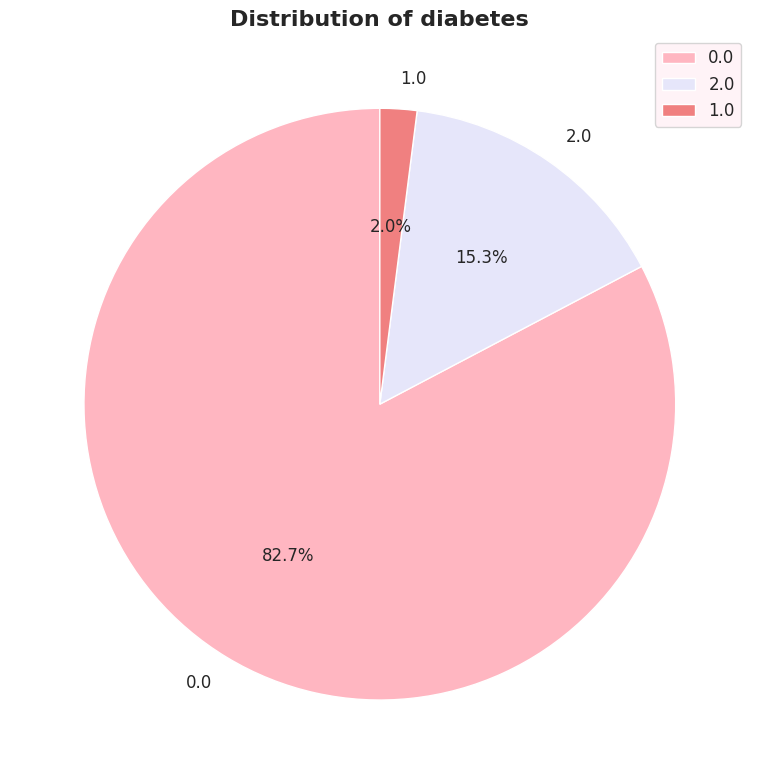

In [ ]:
diabetes_title = f'Distribution of diabetes'
plot_pie_chart_from_column(df, 'diabetes', title=diabetes_title)
# 0 = non diabetics
# 1 = pre diabetics
# 2 = diabetics

## دیابت و سن

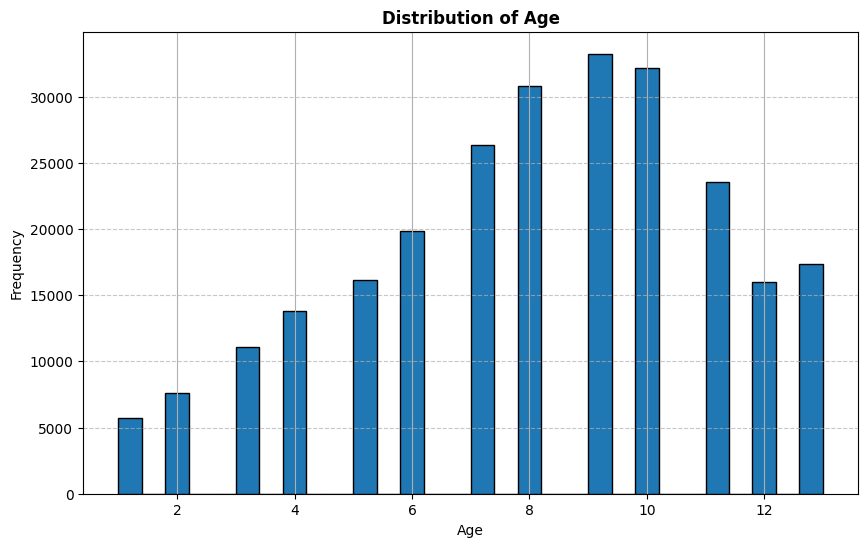

In [ ]:
plot_histogram(df, 'Age', bins=30, title=None)

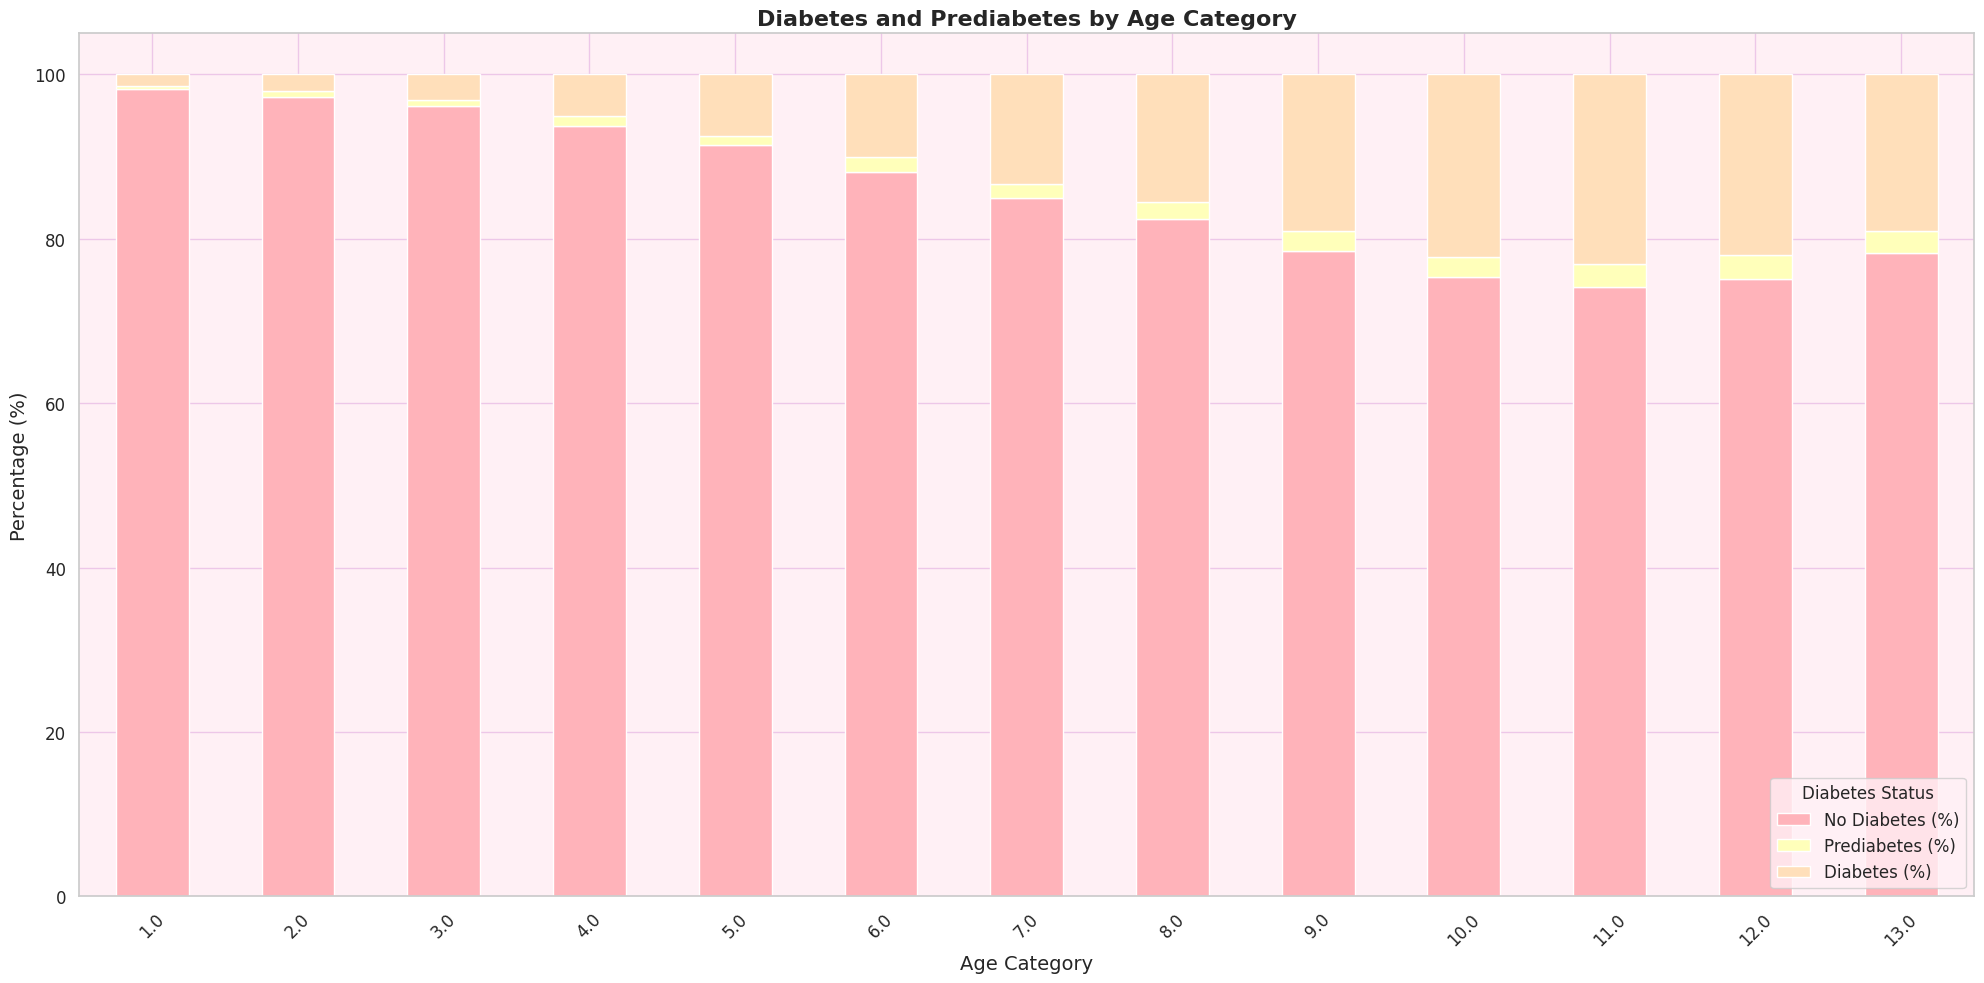

In [ ]:
plot_diabetes_in_numerical(df, 'Age')

diabetes
0.0    7.824230
1.0    9.082091
2.0    9.375958
Name: Age, dtype: float64


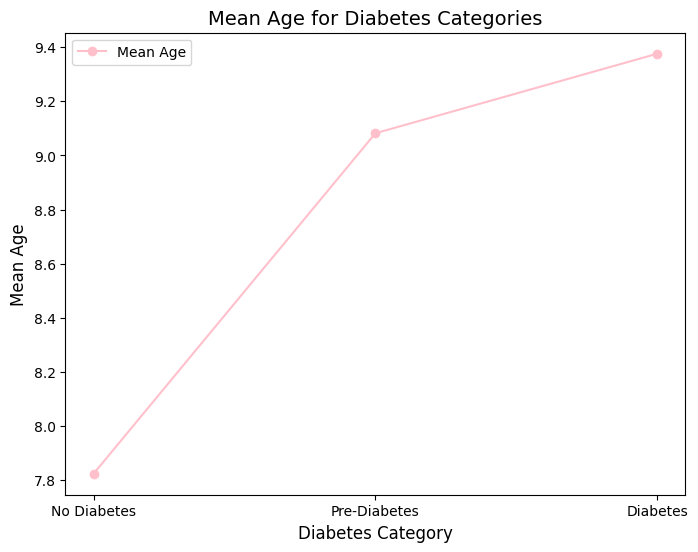

In [ ]:
mean_age_by_diabetes = df.groupby('diabetes')['Age'].mean()

print(mean_age_by_diabetes)

plt.figure(figsize=(8,6))
plt.plot(mean_age_by_diabetes.index, mean_age_by_diabetes, marker='o', linestyle='-', color='pink', label='Mean Age')
plt.title('Mean Age for Diabetes Categories', fontsize=14)
plt.xlabel('Diabetes Category', fontsize=12)
plt.ylabel('Mean Age', fontsize=12)
plt.xticks(ticks=[0, 1, 2], labels=['No Diabetes', 'Pre-Diabetes', 'Diabetes'])
plt.legend()
plt.show()

In [ ]:
age_diabetes_corr = df['Age'].corr(df['diabetes'])
print(age_diabetes_corr)


0.18464157162258393


همبستگی مستقیم ضعیفی بین دیابت و سن وجود دارد. با افزایش سن احتمال ابتلا به دیابت کمی بیشتر میشود.


## دیابت و جنسیت

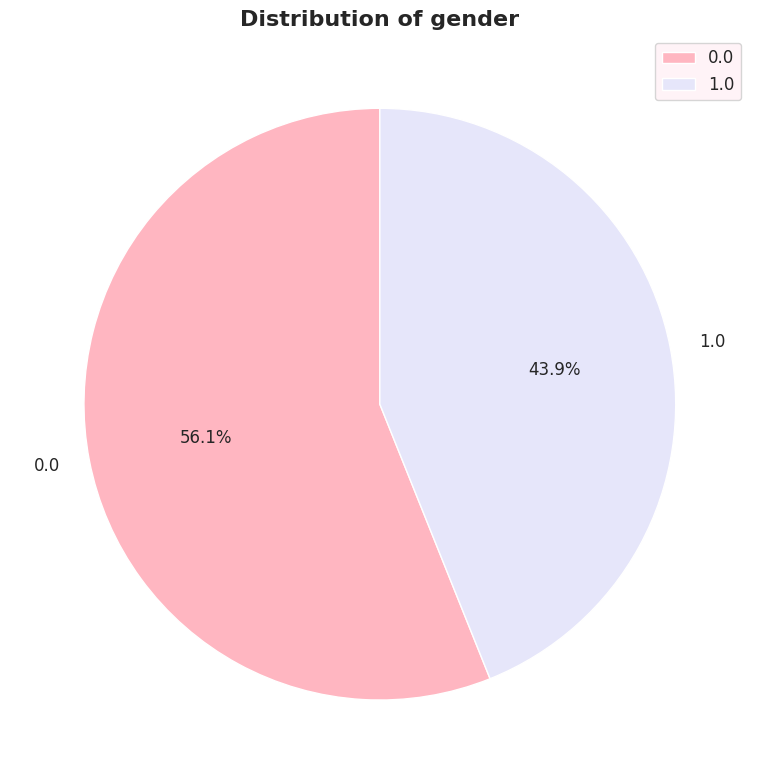

In [ ]:
gender_title = f'Distribution of gender'
plot_pie_chart_from_column(df, 'Sex', title=gender_title)
# 0 = female
# 1 = male

### دیابت در خانم ها شایع تر هست یا اقایون؟

چون تعداد خانم ها در دیتاست بیشتر از اقایون هست به اشتباه در پلات تعداد  خانم های مبتلا به دیابت بیشتر از اقایون مبتلا به دیابت میباشد.  

In [ ]:
female_diabetes = df[df['diabetes'] == 2][df['Sex'] == 0]
male_diabetes = df[df['diabetes'] == 2][df['Sex'] == 1]

print(len(female_diabetes), len(male_diabetes))



18345 16752


<ipython-input-61-1a8d4771e3fc>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_diabetes = df[df['diabetes'] == 2][df['Sex'] == 0]
<ipython-input-61-1a8d4771e3fc>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_diabetes = df[df['diabetes'] == 2][df['Sex'] == 1]


### جواب درست

درصد مردان مبتلا به دیابت: 16.59813528589971
درصد زنان مبتلا به دیابت: 14.237043475561489
درصد مردان پیش‌دیابتی: 2.0064006658277767
درصد زنان پیش‌دیابتی: 2.020891862107501


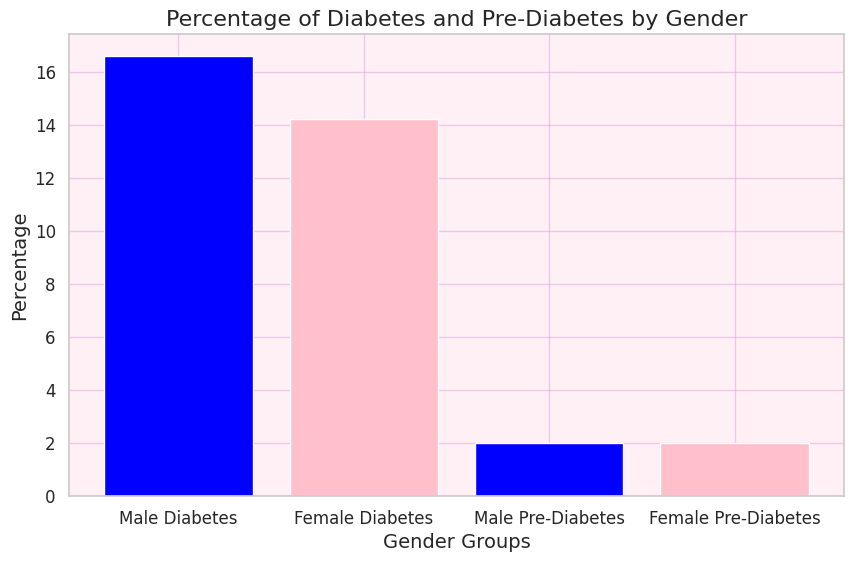

In [ ]:
male_diabetes = df[(df['diabetes'] == 2) & (df['Sex'] == 1)]
total_male_diabetes = len(male_diabetes)

len_male = len(df[df['Sex'] == 1])

female_diabetes = df[(df['diabetes'] == 2) & (df['Sex'] == 0)]
total_female_diabetes = len(female_diabetes)

len_female = len(df[df['Sex'] == 0])

male_pre_diabetes = df[(df['diabetes'] == 1) & (df['Sex'] == 1)]
total_male_pre_diabetes = len(male_pre_diabetes)

female_pre_diabetes = df[(df['diabetes'] == 1) & (df['Sex'] == 0)]
total_female_pre_diabetes = len(female_pre_diabetes)

percent_male_diabetes = (total_male_diabetes / len_male) * 100
percent_female_diabetes = (total_female_diabetes / len_female) * 100

percent_male_pre_diabetes = (total_male_pre_diabetes / len_male) * 100
percent_female_pre_diabetes = (total_female_pre_diabetes / len_female) * 100

print("درصد مردان مبتلا به دیابت:", percent_male_diabetes)
print("درصد زنان مبتلا به دیابت:", percent_female_diabetes)
print("درصد مردان پیش‌دیابتی:", percent_male_pre_diabetes)
print("درصد زنان پیش‌دیابتی:", percent_female_pre_diabetes)

labels = ['Male Diabetes', 'Female Diabetes', 'Male Pre-Diabetes', 'Female Pre-Diabetes']
percentages = [percent_male_diabetes, percent_female_diabetes, percent_male_pre_diabetes, percent_female_pre_diabetes]

plt.figure(figsize=(10, 6))
plt.bar(labels, percentages, color=['blue', 'pink', 'blue', 'pink'])
plt.title('Percentage of Diabetes and Pre-Diabetes by Gender')
plt.ylabel('Percentage')
plt.xlabel('Gender Groups')
plt.show()



In [ ]:

sex_crosstab = pd.crosstab(df['Sex'], df['diabetes'])

chi2, p, dof, expected = stats.chi2_contingency(sex_crosstab)

print('Chi-square:', chi2)
print('p-value:', p)
print('Degrees of freedom:', dof)
print('Expected frequencies:', expected)

if p < 0.05:
    print("ارتباط معناداری بین جنسیت و دیابت وجود دارد.")
else:
    print("ارتباط معناداری بین جنسیت و دیابت وجود ندارد.")


Chi-square: 244.30546543583293
p-value: 8.907221068357717e-54
Degrees of freedom: 2
Expected frequencies: [[106576.9013539    2595.79846027  19681.30018583]
 [ 83478.0986461    2033.20153973  15415.69981417]]
ارتباط معناداری بین جنسیت و دیابت وجود دارد.


دیابت بین مردها رایج تر میباشد.

## فشار خون

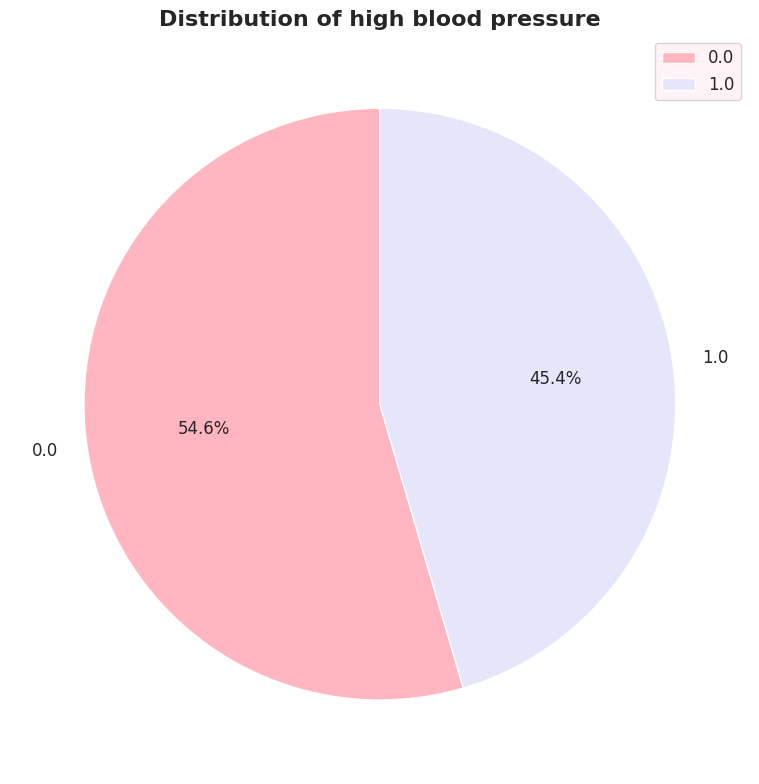

In [ ]:
bp_title = 'Distribution of high blood pressure'
plot_pie_chart_from_column(df, 'HighBP', title=bp_title)

## فشار خون و دیابت

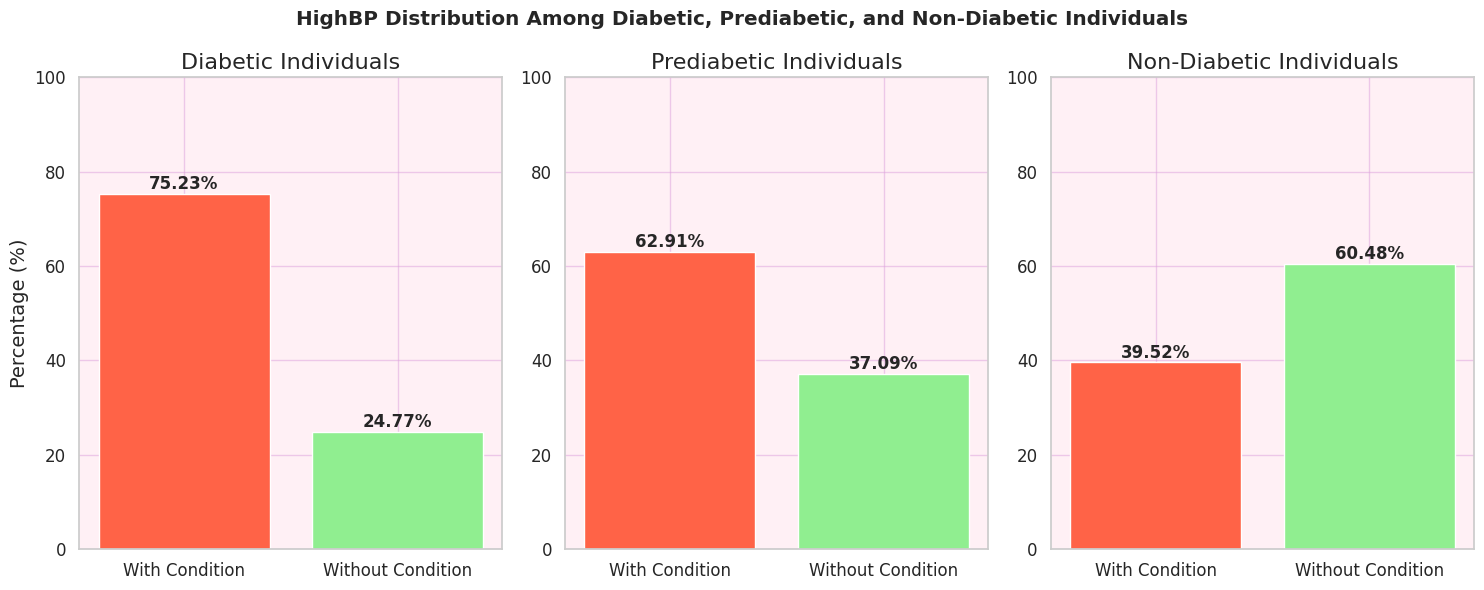

In [ ]:
analyze_diabetes_vs_condition(df, 'HighBP')

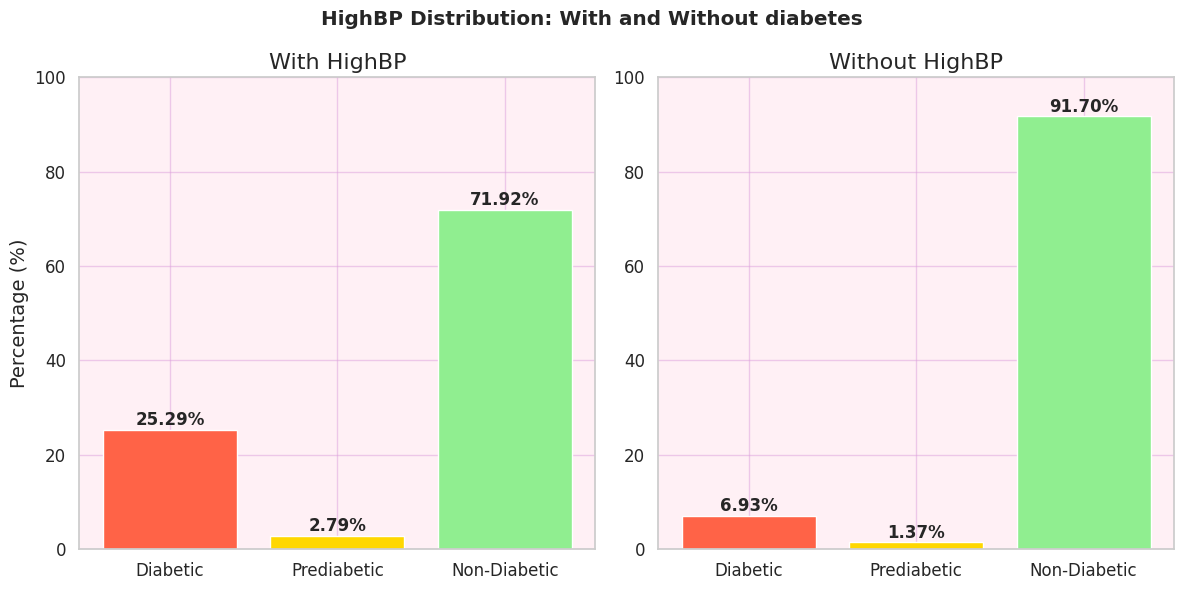

In [ ]:
analyze_condition_vs_diabetes(df, 'HighBP')

In [ ]:
df['HighBP'].corr(df['diabetes'])

 فشار خون بالا بین افراد دیابتی خیلی رایج هست. اما  دیابت بین افراد فشارخون بالا خیلی رایج نیست.

 رابطه ی مستقیم ضعیفی بین دیابت و فشارخون بالا وجود دارد
 اما لزوما هرکسی که فشارخون بالا دارد دیابت ندارد.


## چند درصد از افراد در دیتاست چربی خون بالا دارند؟


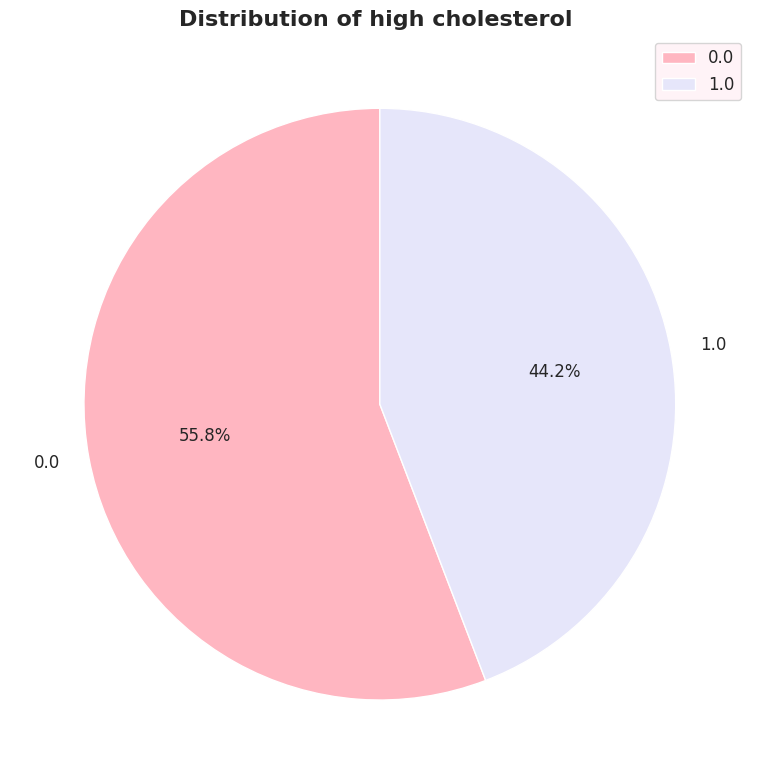

In [ ]:
chol_title = f'Distribution of high cholesterol '
plot_pie_chart_from_column(df, 'HighChol', title=chol_title)

## آیا ارتباطی بین چربی خون بالا و دیابت وجود دارد؟


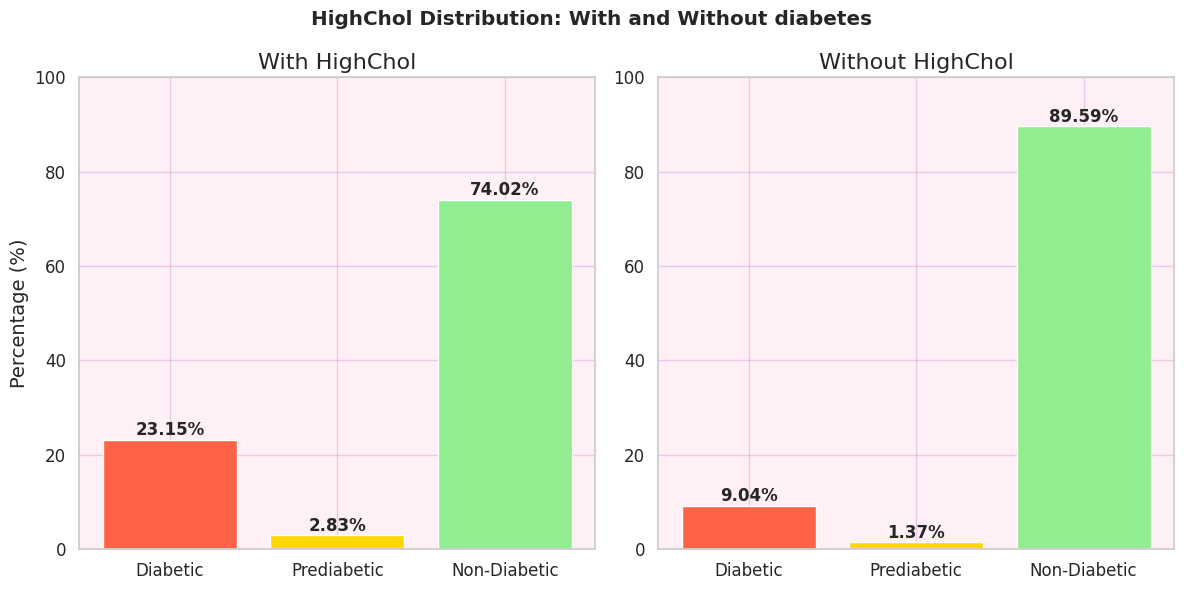

In [ ]:
analyze_condition_vs_diabetes(df, 'HighChol')

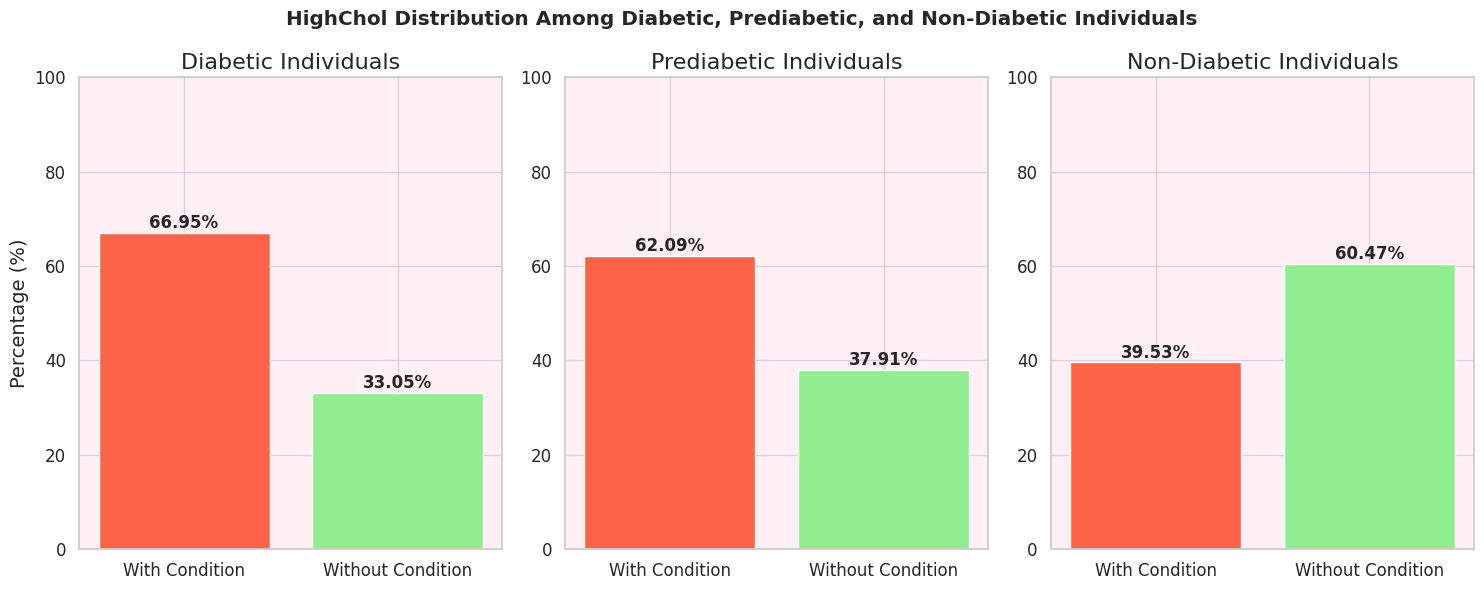

In [ ]:
analyze_diabetes_vs_condition(df, 'HighChol')

In [ ]:
df['HighChol'].corr(df['diabetes'])

## تاثیر فشار خون بالا و چربی خون بالا روی ابتلا به دیابت

In [ ]:
df['HighBP_HighChol'] = df.apply(lambda x: 1 if x['HighBP'] == 1 and x['HighChol'] == 1 else 0, axis=1)
pd.crosstab(df['HighBP_HighChol'], df['diabetes'], normalize='index')


diabetes,0.0,1.0,2.0
HighBP_HighChol,,,
0,0.888618,0.015582,0.095800
1,0.661683,0.032420,0.305896


در گروهی که هر دو عامل
(فشار خون بالا و چربی خون بالا) را ندارند یا فقط یکی از آن‌ها را دارند
بیش از 88% از افراد بدون دیابت هستند.
تنها 9.58% از این افراد دیابت دارند.

در گروهی که هر دو عامل فشار خون و چربی خون بالا را دارند
درصد افرادی که دیابت دارند به طور چشمگیری افزایش یافته و به 30.59% رسیده .
همچنین درصد افرادی که پیش‌دیابت دارند، از 1.56% به 3.24% افزایش یافته.
افرادی که هم فشار خون بالا و هم چربی خون بالا دارند، به طور قابل توجهی بیشتر مستعد ابتلا به دیابت هستند.

## فعالیت فیزیکی و دیابت

In [ ]:
activity_diabetes = pd.crosstab(index=df['PhysActivity'], columns=df['diabetes'], margins=True)
print(activity_diabetes)


diabetes         0.0   1.0    2.0     All
PhysActivity                             
0.0            46743  1489  13038   61270
1.0           143312  3140  22059  168511
All           190055  4629  35097  229781


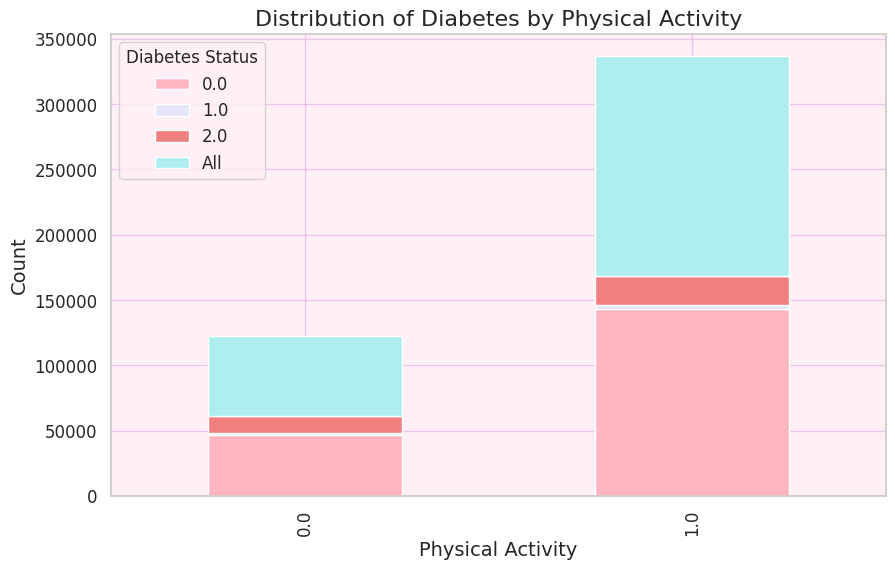

In [ ]:
activity_diabetes.drop('All', inplace=True)
activity_diabetes.plot(kind='bar', stacked=True, figsize=(10, 6), color=pastel_colors)

plt.title('Distribution of Diabetes by Physical Activity')
plt.xlabel('Physical Activity')
plt.ylabel('Count')
plt.legend(title='Diabetes Status')
plt.grid(True)
plt.show()


In [ ]:
chi2_activity, p_activity, dof_activity, ex_activity = chi2_contingency(activity_diabetes)

print(f"Chi-square Activity and Diabetes: {chi2_activity}, P-value: {p_activity}")


Chi-square Activity and Diabetes: 2460.9016468484137, P-value: 0.0


درصد افراد دیابتی در گروه بدون فعالیت فیزیکی: تقریباً 21.29%.


درصد افراد دیابتی در گروه با فعالیت فیزیکی: تقریباً 13.09%.


 افرادی که فعالیت فیزیکی دارند، کمتر مستعد ابتلا به دیابت هستند. درصد افراد دیابتی در میان کسانی که فعالیت فیزیکی ندارند به طور قابل توجهی بیشتر از افرادی است که فعالیت فیزیکی دارند.

## فعالیت فیزیکی و فشار خون

In [ ]:
sns.countplot(x='PhysActivity', hue='HighBP', data=df)

In [ ]:
def perform_chi_square_test(df, first_column, second_column):
    contingency_table = pd.crosstab(df[first_column], df[second_column])
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

    return chi2_stat, p_value, contingency_table, expected

chi2_stat, p_value, contingency_table, expected = perform_chi_square_test(df, 'PhysActivity', 'HighBP')

print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-Value: {p_value}")
print("Contingency Table:\n", contingency_table)
print("Expected Frequencies:\n", expected)

افرادی که فعالیت فیزیکی بیشتری دارند، احتمالاً کمتر از دیگران به فشار خون بالا مبتلا می‌شوند.
همچنین، افرادی که فعالیت فیزیکی ندارند، بیشتر از تعداد مورد انتظار به فشار خون بالا مبتلا هستند.

## فعالیت فیزیکی و کلسترول بالا

In [ ]:
sns.countplot(x='PhysActivity', hue='HighChol', data=df)

chi2_stat, p_value, contingency_table, expected = perform_chi_square_test(df, 'PhysActivity', 'HighChol')
print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-Value: {p_value}")
print("Contingency Table:\n", contingency_table)
print("Expected Frequencies:\n", expected)

افرادی که فعالیت فیزیکی بالایی دارند، نسبت به تعداد مورد انتظار کلسترول طبیعی بیشتری دارند.
در مقابل، افرادی که فعالیت فیزیکی ندارند، تعداد بیشتری از آن‌ها از آنچه انتظار می‌رفت کلسترول بالا دارند.

## فعالیت فیزیکی , جنسیت و دیابت

In [ ]:
phys_contingency_table = pd.crosstab(df['PhysActivity'], df['Sex'])

chi2, p, dof, expected = stats.chi2_contingency(phys_contingency_table)

print('Chi-square:', chi2)
print('p-value:', p)
print('Degrees of freedom:', dof)
print('Expected frequencies:', expected)

if p < 0.05:
    print("فعالیت فیزیکی و جنسیت تاثیر معناداری بر دیابت دارند.")
else:
    print("فعالیت فیزیکی و جنسیت تاثیر معناداری بر دیابت ندارند.")


فعالیت فیزیکی به طور کلی به کاهش احتمال دیابت کمک می‌کند.

جنسیت به طور معناداری بر احتمال دیابت تأثیر دارد.

تاثیر ترکیبی فعالیت فیزیکی و جنسیت: فعالیت فیزیکی تأثیر بیشتری بر کاهش دیابت در مردان

## ارتباط بین فعالیت فیزیکی, فشارخون بالا, چربی خون بالا با دیابت

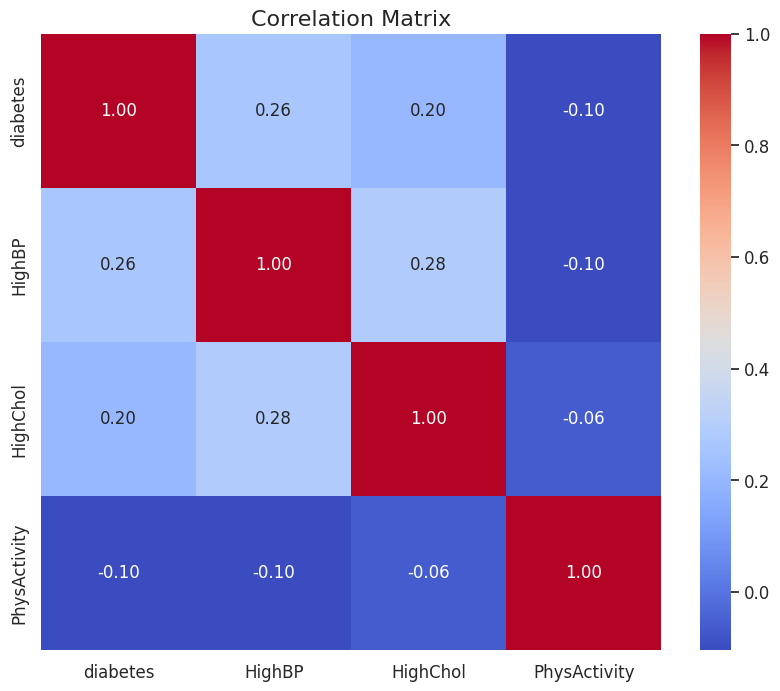

In [ ]:
numeric_columns = ['diabetes', 'HighBP', 'HighChol', 'PhysActivity']
correlation_matrix = df[numeric_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()



   فشار خون بالا و کلسترول بالا هر دو  پیش‌بین‌های قوی برای افزایش احتمال قرار گرفتن در هر یک از دسته‌های دیابت نسبت به دسته غیر دیابتی هستند.

فعالیت بدنی با فشارخون و چربی خون و دیابت همبستگی منفی دارد. یعنی احتمال ابتلا به این بیماری هارا کاهش میدهد.


## توزیع فراوانی شاخص توده بدنی

In [ ]:
bmi_bins = [0, 18.5, 24.9, 29.9, 39.9, 50,  100]
bmi_labels = ['Underweight', ' Normal weight',
          'Overweight', ' Obesity I',
          'Obesity II', 'Obesity III']

df['BMI'] = pd.cut(df['BMI'], bins=bmi_bins, labels=bmi_labels)

plt.figure(figsize=(12, 8))

# Plot each category
for label in bmi_labels:
    sns.histplot(df[df['BMI'] == label]['BMI'], bins=30, kde=True, label=label, alpha=0.5)

plt.title('BMI Distribution by Class')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.legend(title='''BMI Category:
        bmi <18.5= Underweight,
        18.5 to 24.9=Normal weight,
        25 to 29.9=Overweight,
        30 to 34.9=Obesity I,
        35 to 39.9= Obesity II,
        bmi ≥ 40 = Obesity III''' )
plt.grid()
plt.show()

## توزیع دیابت در شاخص توده بدنی

In [ ]:
plot_diabetes_in_numerical(df, 'BMI')

## ارتباط بین دیابت و شاخص توده بدنی با داده های پرت


In [ ]:
sns.boxplot(df, x='BMI', hue='diabetes')

میانگین با داده های پرت

In [ ]:
mean_bmi_by_diabetes_status = df.groupby('diabetes')['BMI'].mean().round().reset_index()
print(mean_bmi_by_diabetes_status)


میانه با داده های پرت

In [ ]:
median_bmi_by_diabetes_status = df.groupby('diabetes')['BMI'].median().reset_index()
print(median_bmi_by_diabetes_status)

تست

In [ ]:
group1 = df[df['diabetes'] == 0]['BMI']
group2 = df[df['diabetes'] == 2]['BMI']
stat, p_value = mannwhitneyu(group1, group2)
print(f'Mann-Whitney U Test Statistic: {stat}, P-Value: {p_value}')


 افراد دیابتی شاخص توده بدنی بالاتری دارند به نسبت اونهایی که دیابت ندارند که یعنی که شاخص توده بدنی بالاتر با افزایش احتمال ابتلا به دیابت مرتبط است.


## ارتباط بین دیابت و شاخص توده بدنی بدون داده های پرت


In [ ]:
df_with_outliers = df[['BMI', 'diabetes']]
plt.figure(figsize=(10, 6))
sns.boxplot(x='BMI', hue='diabetes', data=df_with_outliers)
plt.title('BMI vs Diabetes with Outliers')
plt.xlabel('BMI')
plt.ylabel('Diabetes')
plt.show()
Q1 = df['BMI'].quantile(0.25)
Q3 = df['BMI'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_without_outliers = df[(df['BMI'] >= lower_bound) & (df['BMI'] <= upper_bound)]

plt.figure(figsize=(10, 6))
sns.boxplot(x='BMI', hue='diabetes', data=df_with_outliers)
plt.title('BMI vs Diabetes without Outliers')
plt.xlabel('BMI')
plt.ylabel('Diabetes')
plt.show()

df_without_outliers['BMI'].mean()
df_without_outliers['BMI'].median()

میانگین بدون داده های پرت

In [ ]:
mean_bmi_without_outliers = df_without_outliers.groupby('diabetes')['BMI'].mean().round().reset_index()
print(mean_bmi_without_outliers)

میانه بدون داده های پرت

In [ ]:
median_bmi_without_outliers = df_without_outliers.groupby('diabetes')['BMI'].median().reset_index()
print(median_bmi_without_outliers)

تست

In [ ]:
group1 = df_without_outliers[df_without_outliers['diabetes'] == 0]['BMI']
group2 = df_without_outliers[df_without_outliers['diabetes'] == 2]['BMI']
stat, p_value = mannwhitneyu(group1, group2)
print(f'Mann-Whitney U Test Statistic: {stat}, P-Value: {p_value}')


نتیجه فرقی نکرد. حذف داده‌های پرت تاثیری بر نتیجه کلی ندارد.



## ارتباط شاخص توده بدنی با فاکتور های مختلف

In [ ]:
life_style_factors = ['BMI', 'Age', 'Fruits', 'Veggies', 'Income', 'Education']
sns.heatmap(df[life_style_factors].corr(), annot=True)

In [ ]:
for factor in life_style_factors:
    crosstab = pd.crosstab(df['diabetes'], df[factor])
    print(f'Cross table for Diabetes and {factor}:')
    print(crosstab)
    print('\n')

با افزایش سن شاخص توده بدنی کمتر میشه.


افرادی که
 حداقل یکبار در روز مصرف میوه و سبزیجات دارند شاخص توده بدنی پایین تر دارند.

 میزان تحصیلات/ درامد و شاخص توده بدنی همبستگی منفی دارند.


 شاخص توده بدنی بالاتر، با افزایش
 احتمال دیابت ارتباط دارد.

 افزایش سن با افزایش احتمال دیابت مرتبط است.

  مصرف بیشتر میوه‌ها با کاهش احتمال دیابت مرتبط است.

  مصرف بیشتر سبزیجات می‌تواند به کاهش احتمال دیابت کمک کند.

درآمد بالاتر با کاهش احتمال دیابت مرتبط است.

 تحصیلات بالاتر با کاهش احتمال دیابت ارتباط دارد.


## شاخص توده بدنی و جنسیت

In [ ]:
median_bmi_male = df[df['Sex'] == 1]['BMI'].median()
median_bmi_female = df[df['Sex'] == 0]['BMI'].median()


print(f'Median BMI of male: {median_bmi_male}')
print(f'Median BMI of female: {median_bmi_female}')

In [ ]:
bmi_group1 = df[df['Sex'] == 0]['BMI']
bmi_group2 = df[df['Sex'] == 1]['BMI']
stat, p_value = mannwhitneyu(bmi_group1, bmi_group2)
print(f'Mann-Whitney U Test Statistic: {stat}, P-Value: {p_value}')

NameError: name 'mannwhitneyu' is not defined

تحلیل:

بطور میانگین مرد ها شاخص توده بدنی بیشتری به نسبت خانم ها دارند.



## شاخص توده بدنی, فشار خون بالا , سن و دیابت

In [ ]:
odds_ratios = np.exp(result.params)
print(odds_ratios)
odds_ratios = {
    'Variable': ['HighBP', 'BMI', 'Age'],
    'Odds Ratio': [2.852832, 1.074424, 1.172583]
}
odds_df = pd.DataFrame(odds_ratios)

plt.figure(figsize=(8, 5))
sns.barplot(x='Odds Ratio', y='Variable', data=odds_df, color='skyblue')
plt.axvline(x=1, color='red', linestyle='--')
plt.title('Odds Ratios for Diabetes Risk Factors')
plt.xlabel('Odds Ratio')
plt.ylabel('Predictor Variable')
plt.show()

افرادی که فشار خون بالا دارند، حدود 2.85 برابر بیشتر احتمال دیابت دارند.

با هر واحد افزایش شاخص توده بدنی احتمال ابتلا به دیابت حدود 7.44% افزایش میابد.

با هر سال افزایش سن احتمال دیابت حدود 17.26% افزایش میابد.



## توزیع فراوانی سیگاری ها

In [ ]:
smoking_title = 'Distribution of smoking'
plot_pie_chart_from_column(df, 'Smoker', title=smoking_title)

تعداد افراد دیابتی بین افراد سیگاری بیشتر از افرادی دیابتی ای است که سیگار نمیکشند.


##  رابطه ی بین افراد سیگاری و  وضعیت سلامت عمومی انها

In [ ]:
smoker_contingency_table = pd.crosstab(df['Smoker'], df['GenHlth'])

chi2, p, dof, ex = chi2_contingency(smoker_contingency_table)
print(f'Chi-Square Statistic: {chi2}, P-Value: {p}')

In [ ]:
sns.heatmap(smoker_contingency_table, annot=True, fmt='d', cmap='Blues', cbar=True, square=True)


افراد سیگاری سلامت عمومی کمتری نسبت به افرادی که سیگار نمیکشند دارند.

افرادی که سیگار نمیکشند سلامت عمومی خیلی بهتری نسبت به سیگاری ها دارند.

## سیگار و دیابت

In [ ]:
analyze_condition_vs_diabetes(df, 'Smoker')
smoker_diabetes_contingency_table = pd.crosstab([df['diabetes'], df['GenHlth']], df['Smoker'])

chi2_stat, p_val, dof, expected = chi2_contingency(smoker_diabetes_contingency_table)
print(f"Chi-Square Statistic: {chi2_stat}, P-Value: {p_val}")

sns.heatmap(smoker_diabetes_contingency_table, annot=True, cmap='Blues', fmt='d')



تعداد افراد سیگاری که دیابت دارند سلامت عمومی کمتری نسبت به افراد دیابتی که سیگار نمیکشند دارند.


## سکته

In [ ]:
stroke_title = 'Distribution of stroke'
plot_pie_chart_from_column(df, 'Stroke', title=stroke_title)
# 0 = no
# 1 = yes

In [ ]:
analyze_condition_vs_diabetes(df, 'Stroke')

## دیابت و سکته

In [ ]:
stroke_diabetes_crosstab = pd.crosstab(df['Stroke'], df['diabetes'])

sns.heatmap(stroke_diabetes_crosstab, annot=True, cmap='Blues', fmt='d')



 تقریبا ۳ درصد افرادی که سکته کرده اند دیابت نداشتند.

 حدودا ۶ درصد افرادی که سکته کرده اند پیش دیابتی بودند.

 حدودا ۹ درصد افرادی که سکته کردند دیابتی بودند.

 افرادی که سابقه سکته دارند، بیشتر از افراد بدون سابقه سکته مستعد ابتلا به دیابت هستند.

## بیماری قلبی یا حمله قلبی

In [ ]:
heart_disease_title = 'Distribution of heart disease'
plot_pie_chart_from_column(df, 'HeartDiseaseorAttack', title=heart_disease_title)
# 0 = no
# 1 = yes

analyze_condition_vs_diabetes(df, 'HeartDiseaseorAttack')

## بیماری قلبی و دیابت

In [ ]:
heart_disease_diabetes_crosstab = pd.crosstab(df['HeartDiseaseorAttack'], df['diabetes'])
print(heart_disease_diabetes_crosstab)
sns.heatmap(heart_disease_diabetes_crosstab, annot=True, cmap='Blues', fmt='d')


In [ ]:
df['HeartDiseaseorAttack'].corr(df['diabetes'])

بین بیماران قلبی:

حدود ۶۴ در صد دیابت ندارند

حدود ۳ درصد پیش دیابت دارند

حدود ۳۳ درصد دیابت دارند.


بین افرادی که بیماری قلبی ندارند:

حدود ۸۶ درصد دیابت ندارند.

حدود ۲ درصد پیش دیابت دارند

حدود ۱۴ درصد دیابت دارند.

افرادی که بیماری قلبی دارند، بیشتر مستعد ابتلا به دیابت هستند.
 درصد افراد دیابتی در میان کسانی که دارای بیماری قلبی هستند، تقریباً دو برابر افراد دیابتی است که بیماری قلبی ندارند.

## ساخت جدول تلاقی برای سکته مغزی، بیماری قلبی، و دیابت


In [ ]:
stroke_heart_diabetes = pd.crosstab(index=[df['Stroke'], df['HeartDiseaseorAttack']], columns=df['diabetes'])
print(stroke_heart_diabetes)

chi2_stroke, p_stroke, dof_stroke, ex_stroke = chi2_contingency(pd.crosstab(df['Stroke'], df['diabetes']))
print(f"Chi-square Stroke and Diabetes: {chi2_stroke}, P-value: {p_stroke}")

chi2_heart, p_heart, dof_heart, ex_heart = chi2_contingency(pd.crosstab(df['HeartDiseaseorAttack'], df['diabetes']))
print(f"Chi-square Heart Disease and Diabetes: {chi2_heart}, P-value: {p_heart}")

chi2_combined, p_combined, dof_combined, ex_combined = chi2_contingency(pd.crosstab([df['Stroke'], df['HeartDiseaseorAttack']], df['diabetes']))
print(f"Chi-square Combined Stroke, Heart Disease and Diabetes: {chi2_combined}, P-value: {p_combined}")



هر دو فاکتور سکته و بیماری قلبی به‌طور جداگانه و ترکیبی تأثیر قابل توجهی بر دیابت دارند و نمی‌توان روابط آنها را تصادفی در نظر گرفت.

## مصرف میوه‌ها و سبزیجات

In [ ]:
fruits_veggies = ['Fruits', 'Veggies']
[plot_pie_chart_from_column(df, column, title=f'Distribution of {column}') for column in fruits_veggies]


## مصرف میوه‌ها و سبزیجات و دیابت

In [ ]:
[analyze_condition_vs_diabetes(df, column) for column in fruits_veggies]


همبستگی معکوس ضعیفی بین مصرف سبزیجات و میوه با دیابت وجود دارد.
 تعداد افراد دیابتی بین افرادی که
روزانه یک یا بیشتر از یکبار میوه و سبزیجات مصرف نمیکنند بیشتر از افرادی است که مصرف میکنند.

## مصرف الکل سنگین


In [ ]:
plot_pie_chart_from_column(df, 'HvyAlcoholConsump', title='Distribution of heavy alcohol consumption ')
analyze_condition_vs_diabetes(df, 'HvyAlcoholConsump')

In [ ]:
df['HvyAlcoholConsump'].corr(df['diabetes'])

In [ ]:
HvyAlcoholConsump_crosstab = pd.crosstab(df['HvyAlcoholConsump'], df['diabetes'])
print(HvyAlcoholConsump_crosstab)

In [ ]:
df['HvyAlcoholConsump'].corr(df['BMI'])

-0.058334009406632706

-0.058334009406632706

<Axes: xlabel='BMI'>

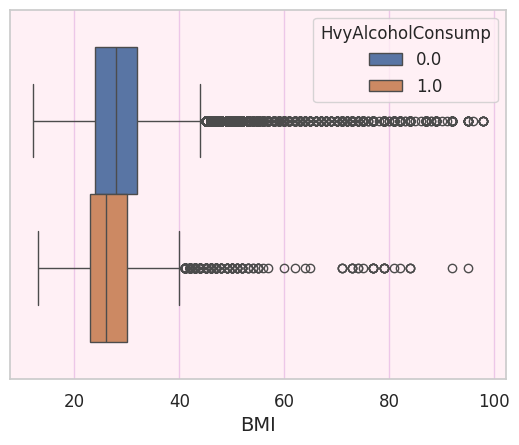

In [ ]:
sns.boxplot(df, x='BMI', hue='HvyAlcoholConsump')

نوشیدن الکل رابطه ی تاثیرگذاری با دیابت ندارد.

## مصرف الکل و سیگار

In [ ]:
crosstab = pd.crosstab(
    index=[df['HvyAlcoholConsump'], df['Smoker']],
    columns=df['diabetes'],
    margins=True,
    margins_name='Total'
)

print(crosstab)


سیگار کشیدن و مصرف الکل زیاد میتواند کمی احتمال ابتلا به دیابت را افزایش دهد.

##  سلامت عمومی


Would you say that in general your health is: scale 1-5 1 = excellent 2 = very good 3 = good 4 = fair 5 = poor


In [ ]:
countplot(df, 'GenHlth')

## سلامت عمومی و دیابت

In [ ]:
plot_diabetes_in_numerical(df, 'GenHlth')
# normalize=True

In [ ]:
genhlth_diabetes = pd.crosstab(index=df['GenHlth'], columns=df['diabetes'], margins=True)
print(genhlth_diabetes)

## فعالیت فیزیکی و سلامت عمومی

In [ ]:

sns.boxplot(x='PhysActivity', y='GenHlth', data=df)

high_activity_health = df[df['PhysActivity'] == 1]['GenHlth']
low_activity_health = df[df['PhysActivity'] == 0]['GenHlth']

print('وضعیت سلامت برای افراد با فعالیت فیزیکی بالا:')
print(high_activity_health.describe())

print('وضعیت سلامت برای افراد با فعالیت فیزیکی پایین:')
print(low_activity_health.describe())


stat, p_value = stats.mannwhitneyu(high_activity_health, low_activity_health)

print(f'Mann-Whitney U Statistic: {stat}, p-value: {p_value}')


# 5. تفسیر نتایج
alpha = 0.05  # سطح معنی‌داری
if p_value < alpha:
    print("نتیجه معنادار است: افرادی که فعالیت فیزیکی بالا دارند، وضعیت سلامت بهتری دارند.")
else:
    print("نتیجه معنادار نیست: تفاوت معناداری بین دو گروه وجود ندارد.")


هرچه وضعیت سلامتی عمومی کاهش پیدا میکند تعداد افراد دیابتی هم بیشتر میشود.
این نشان دهنده ی این است که سلامت عمومی افراد دیابتی خوب نیست.

## سلامت روانی و فیزیکی

Now thinking about your physical health, which includes physical illness and injury, for how many days during the past 30 days was your physical health not good? scale 1-30 days

Now thinking about your mental health, which includes stress, depression, and problems with emotions, for how many days during the past 30 days was your mental health not good? scale 1-30 days

In [ ]:
ment_phys_list = ['MentHlth', 'PhysHlth']
[plot_diabetes_in_numerical(df, column) for column in ment_phys_list]


## سلامت روانی و فیزیکی و دیابت

In [ ]:
sns.boxplot(df, x='PhysHlth', hue='diabetes')

In [ ]:
sns.boxplot(df, x='MentHlth', hue='diabetes')

In [ ]:
diabetes_phys_mean = df.groupby('diabetes')['PhysHlth'].mean().round()
diabetes_ment_mean = df.groupby('diabetes')['MentHlth'].mean().round()

diabetes_phys_mean, diabetes_ment_mean


افراد دیابتی تعداد روز های بیشتری دچار مشکلات سلامتی جسمی میشوند.

افرادی که دیابت ندارند بطور میانگین روزهای کمتری درگیر مشکلات روان هستند.

## سلامت روانی و فیزیکی و وضعیت سلامت عمومی

In [ ]:
sns.boxplot(df, x='PhysHlth', hue='GenHlth')

In [ ]:
sns.boxplot(df, x='MentHlth', hue='GenHlth')

هرچه وضعیت سلامت عمومی بدتر میشود تعداد روزهای درگیر با مشکلات روان هم بیشتر میشود.
افرادی که سلامت عمومی عالی ای دارند
روزهای بسیار کمتری درگیر مشکلات روحی میشوند.

## سلامت روانی و فعالیت فیزیکی

In [ ]:
sns.boxplot(df, x='MentHlth', hue='PhysActivity')

تعداد روزهایی که افرادی که فعالیت فیزیکی دارند درگیر مشکلات روان هستند تقریبا نصف افرادیست که فعالیت فیزیکی ندارند.

## سلامت روانی و فعالیت فیزیکی و دیابت

In [ ]:
sns.boxplot(df, x='MentHlth', y='PhysActivity', hue='diabetes')
plt.legend(loc='lower right')

In [ ]:
X = df[['MentHlth', 'PhysActivity']]
y = df['diabetes']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

سلامت روانی ضعیف به طور معناداری به وضعیت سلامت عمومی بدتر (بر اساس ضریب سلامت روانی) و احتمال افزایش دیابت مرتبطه. همچنین، فعالیت فیزیکی به طور معناداری با کاهش احتمال دیابت مرتبطه.

فعالیت فیزیکی میتواند روزهای درگیر مشکلات روحی را در افراد دیابتی کم کند.


## مشکل در راه رفتن

In [ ]:
diff_walk_title = f'Distribution of difficulty in walking'
plot_pie_chart_from_column(df, 'DiffWalk', title=diff_walk_title)

## مشکل در راه رفتن و دیابت

In [ ]:
analyze_condition_vs_diabetes(df, 'DiffWalk')

In [ ]:
diffWalk_contingency_table = pd.crosstab(df['DiffWalk'], df['diabetes'])
chi2, p, dof, expected = stats.chi2_contingency(diffWalk_contingency_table)

print('Chi-square:', chi2)
print('p-value:', p)
print('Degrees of freedom:', dof)
print('Expected frequencies:', expected)

مشکل در راه رفتن با وضعیت دیابت ارتباط مستقیم داره و این ارتباط تصادفی نیست.
تعداد افراد دیابتی که مشکل در راه
رفتن دارند بیشتر از ۲ برابر دیابتی هایی است که مشکلی ندارند.

همچنین, چون فعالیت فیزیکی کمتر با میزان ابتلا به دیابت رابطه ی مستقیم دارد, احتمال دارد افرادی که مشکل در راه رفتن دارند به دلیل محدودیت فعالیت فیزیکی، بیشتر مستعد دیابت باشند.


## **رابطه ی بین دیابت و درامد و تحصیلات**

In [ ]:
social_status = ['Income', 'Education']
for column in social_status:
  plot_diabetes_in_numerical(df, column)

In [ ]:
social_status_corr_list = ['Income', 'Education', 'diabetes']

corr_social_status = df[social_status_corr_list].corr()
print(corr_social_status)
sns.heatmap(corr_social_status, annot=True)

همبستگی مستقیم متوسطی بین درامد بالا و تحصیلات بالا وجود دارد.
یعنی به احتمال متوسطی تحصیلات بالاتر درامد بالاتری نیز خواهد داشت.
همبستگی معکوس ضعیفی بین دیابت و درامد و تحصیلات وجود دارد. یعنی با بیشتر شدن درامد و تحصیلات احتمال دیابت کمی کمتر میشود.

## heatmap

In [ ]:
correlation_full_health = df.corr()

axis_corr = sns.heatmap(
correlation_full_health,
vmin=-1, vmax=1, center=0,
cmap=sns.diverging_palette(50, 500, n=500),
square=True
)

plt.show()

## pairplot

In [ ]:
sns.pairplot(df.sample(1000))

## **مدل اماری**

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X = df[['BMI', 'PhysActivity', 'HighBP', 'HighChol',
        'Age', 'Smoker', 'Stroke', 'HeartDiseaseorAttack',
        'Sex', 'PhysHlth', 'MentHlth', 'Income', 'Education',
        'HvyAlcoholConsump', 'Veggies', 'Fruits', 'DiffWalk']]
y = df['diabetes']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

print("Classification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[54104   131  2573]
 [ 1283 55658   424]
 [ 8612   982 47283]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.95      0.90     56808
         1.0       0.98      0.97      0.98     57365
         2.0       0.94      0.83      0.88     56877

    accuracy                           0.92    171050
   macro avg       0.92      0.92      0.92    171050
weighted avg       0.92      0.92      0.92    171050



In [ ]:


X = df[['BMI', 'PhysActivity', 'HighBP', 'HighChol',
        'Age', 'Smoker', 'Stroke', 'HeartDiseaseorAttack',
        'Sex', 'PhysHlth', 'MentHlth', 'Income', 'Education',
        'HvyAlcoholConsump', 'Veggies', 'Fruits', 'DiffWalk']]
y = df['diabetes']
# استفاده از ترکیب SMOTE و undersampling
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators=50, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

print("Classification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[26652    14  1548]
 [  585 54235   869]
 [ 2429  1135 46961]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92     28214
         1.0       0.98      0.97      0.98     55689
         2.0       0.95      0.93      0.94     50525

    accuracy                           0.95    134428
   macro avg       0.94      0.95      0.95    134428
weighted avg       0.95      0.95      0.95    134428



 مدل جنگل تصادفی با دقت کلی 0.95 توانست به درستی وضعیت دیابت را پیش‌بینی کند

 دقت و فراخوانی بالا در همه کلاس‌ها نشان‌دهنده این است که مدل قادر به پیش‌بینی دقیق وضعیت دیابت است.

 ترکیب

 SMOTE
 و
 undersampling

  تأثیر بسیار مثبتی بر روی دقت و فراخوانی مدل داشته است.

**Confusion Matrix**:

True Negatives (TN): 26652 - تعداد نمونه‌هایی که به درستی به عنوان غیر دیابتی طبقه‌بندی شده‌اند.

False Negatives (FN): 1548 - تعداد نمونه‌هایی که به اشتباه به عنوان غیر دیابتی طبقه‌بندی شده‌اند.

True Positives (TP): 54235 - تعداد نمونه‌هایی که به درستی به عنوان پیش‌دیابتی طبقه‌بندی شده‌اند.

False Positives (FP): 869 - تعداد نمونه‌هایی که به اشتباه به عنوان پیش‌دیابتی طبقه‌بندی شده‌اند.

True Positives (TP): 46961 - تعداد نمونه‌هایی که به درستی به عنوان دیابتی طبقه‌بندی شده‌اند.

False Positives (FP): 1135 - تعداد نمونه‌هایی که به اشتباه به عنوان دیابتی طبقه‌بندی شده‌اند.

گزارش طبقه‌بندی (Classification Report):

دقت کلی (Accuracy): 0.95 - مدل عملکرد بسیار خوبی دارد.

دقت (Precision) و فراخوانی (Recall):

کلاس 0 (غیر دیابتی):

دقت: 0.90

فراخوانی: 0.94

کلاس 1 (پیش‌دیابتی):

دقت: 0.98

فراخوانی: 0.97

کلاس 2 (دیابتی):

دقت: 0.95

فراخوانی: 0.93



**عوامل مهم در پیش بینی دیابت**

شاخص توده بدنی بالا به شدت با احتمال بیشتر دیابت مرتبط است.

کمبود فعالیت فیزیکی میتونه ریسک دیابت رو افزایش بده

فشار خون بالا با دیابت ارتباط مستقیم دارد

چربی خون بالا یکی از عوامل موثر در افزایش ریسک دیابت است.

افزایش سن احتمال ابتلا به دیابت را افزایش میدهد.



# **توصیه**

کنترل وزن و فعالیت فیزیکی منظم می‌تواند به کاهش احتمال ابتلا به دیابت کمک کند.

فعالیت فیزیکی با فشارخون و چربی خون و دیابت همبستگی منفی دارد. یعنی احتمال ابتلا به این بیماری هارا کاهش میدهد.
 و چون ترکیب چربی خون بالا و فشارخون بالا احتمال ابتلا به دیابت را افزایش میدهد فعالیت فیزیکی میتواند احتمال بروز این بیماری هارا کم کند و در نهایت احتمال دیابت نیز کم میشود.
[کد](https://colab.research.google.com/drive/129fffUV3AMuIU4yquFlHWBzYXRULHGK6?authuser=1#scrollTo=Nt-uSIG_6DlS)




افرادی که
 حداقل یکبار در روز مصرف میوه و سبزیجات دارند شاخص توده
  بدنی پایین تر دارند پس مصرف میوه و سبزیجات توصیه میشود.
[میوه و سبزیحات](https://colab.research.google.com/drive/129fffUV3AMuIU4yquFlHWBzYXRULHGK6?authuser=1#scrollTo=-07PwNSv9y-5)

[bmi و میوه](https://colab.research.google.com/drive/129fffUV3AMuIU4yquFlHWBzYXRULHGK6?authuser=1#scrollTo=-Pmcmv9Z7X4f)



 میزان تحصیلات/ درامد و شاخص توده بدنی همبستگی منفی دارند.
درآمد بالاتر با کاهش احتمال دیابت مرتبط است.
[کد](https://colab.research.google.com/drive/129fffUV3AMuIU4yquFlHWBzYXRULHGK6?authuser=1#scrollTo=yroltR0nA1-6)

سلامت روانی ضعیف به طور معناداری به وضعیت سلامت عمومی بدتر (بر اساس ضریب سلامت روانی) و احتمال افزایش دیابت مرتبطه. همچنین، فعالیت فیزیکی به طور معناداری با کاهش احتمال دیابت مرتبطه

**فعالیت فیزیکی میتواند تعداد روزهای درگیر مشکلات روحی افراد دیابتی را کمتر کند.**
[کد](https://colab.research.google.com/drive/129fffUV3AMuIU4yquFlHWBzYXRULHGK6?authuser=1#scrollTo=vhZ2Hhve_Vnb)




دیتاست:


https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset